In [84]:
# Tom
# Package Imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.dummy import DummyRegressor, DummyClassifier

#New imports for our Pipeline workflows
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

#New imports from imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import warnings
from pprint import pprint


In [2]:
df = pd.read_csv('../data/original_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

State, phone number, intl plan, voice mail plan are objects -- need to encode

Account Length - maybe days, how long customer has been with company

6 - 18 Usage Stats = number of calls number of minutes and charge for different time categories.

19 - # of customer service calls

Possible Churn Indicators:

- By State?
- High Customer Service Contact = high churn?
- Low Calls/Low minutes = higher churn?
- Can we identify a customer profile that is likely to churn for targeted marketing/incentives?
- Drop Phone number -- basically a unique identifer for every customer, not likely to help in predictions

- Location
    - State/Area Code
    
- Duration
    - Account Length
    
- Plan Types
    - Intl / Voicemail
    
- Usage Stats
    - minutes
    - num calls
    - charges
    - customer service calls

Drop Phone number

Encoding Process:
    - voicemail plan = labelencoder 1/0
    - international plan = 1/0
    - state - onehot encoding

Scale Numerical Features





In [4]:
# Drop phone number from the data set--in this context, it acts as a unique identifier with little meaningful context.
df.drop('phone number', axis=1, inplace=True)

Churn rate by state

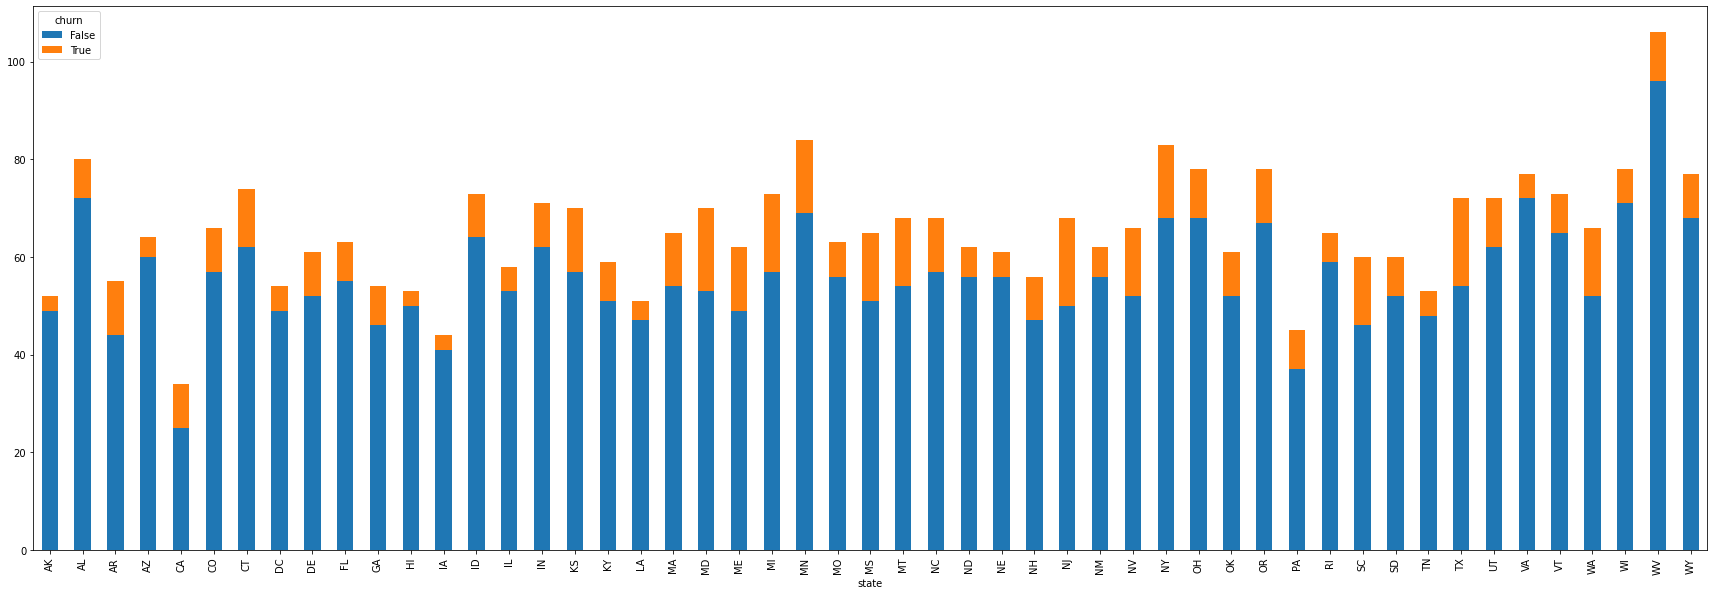

In [5]:
df.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)); 

In [6]:
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

Churn rate by area code

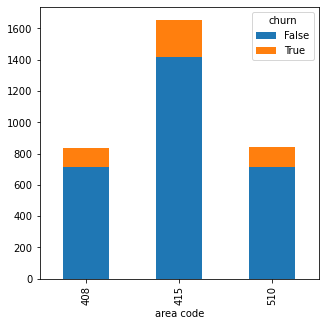

In [7]:
df.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5));

churn rate by voice mail plan

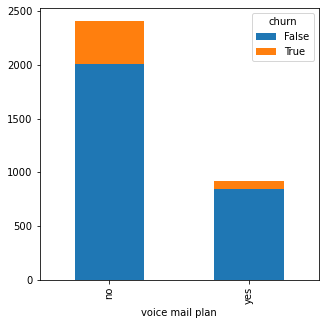

In [8]:
df.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5));

# Train Test Split

In [9]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 2360 to 3174
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2233 non-null   object 
 1   account length          2233 non-null   int64  
 2   area code               2233 non-null   int64  
 3   international plan      2233 non-null   object 
 4   voice mail plan         2233 non-null   object 
 5   number vmail messages   2233 non-null   int64  
 6   total day minutes       2233 non-null   float64
 7   total day calls         2233 non-null   int64  
 8   total day charge        2233 non-null   float64
 9   total eve minutes       2233 non-null   float64
 10  total eve calls         2233 non-null   int64  
 11  total eve charge        2233 non-null   float64
 12  total night minutes     2233 non-null   float64
 13  total night calls       2233 non-null   int64  
 14  total night charge      2233 non-null

In [11]:
X_train['voice mail plan'].value_counts()

no     1621
yes     612
Name: voice mail plan, dtype: int64

In [12]:
# Define datatype of columns
num_cols = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
cat_cols = [0, 3, 4]

# IMBLearn Pipeline for SMOTE

In [13]:
# Google says avg churn rate is 22% for all providers, much lower for the major ones

sm = SMOTE(sampling_strategy=0.75, random_state=42)

In [14]:
# Define functions to identify and select columns based on the datatype stored in that column.
def get_numeric(df):
    return df.select_dtypes(include=['float64', 'int64'])

def get_categorical(df):
    return df.select_dtypes(include=['bool', 'object'])


# Create transformer objects using our get functions
GetNumeric = FunctionTransformer(get_numeric)
GetCategories = FunctionTransformer(get_categorical)

In [15]:
# Subpipelines to select and scale our numeric data / select and one-hot encode our categorical data.
subpipe_num = Pipeline(steps=[('num', GetNumeric),
                                ('ss', StandardScaler())])
 
subpipe_ohe = Pipeline(steps=[('cat', GetCategories), 
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

subpipe_ord = Pipeline(steps=[('ord', OrdinalEncoder())])

In [16]:
# Create lists of numeric and categorical columns.
num_cols = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
num_cols = list(df.columns[num_cols])
cat_cols = ['state']
ord_cols = [3, 4]
ord_cols = list(df.columns[ord_cols])

# Create ColumnTransformer object that contains our subpipes for column transformation
CT = ColumnTransformer(transformers=[
                                    ('subpipe_num', subpipe_num, num_cols),
                                    ('subpipe_ohe', subpipe_ohe, cat_cols),
                                    ('subpipe_ord', subpipe_ord, ord_cols)]
                      )

In [17]:
# Template, any model can be appended to the end.
template_model_pipe = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('dc', DummyClassifier(strategy='most_frequent', random_state=42))
                                       ]
                                )

In [18]:
template_model_pipe.fit(X_train, y_train)
template_model_pipe.score(X_train, y_train)

0.8553515450067174

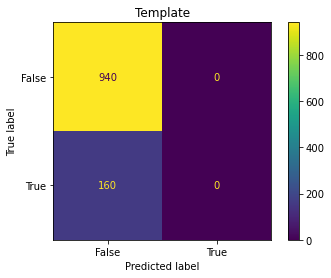

In [19]:
plot_confusion_matrix(template_model_pipe, X_test, y_test)
title = 'Template'
plt.title(title);

# Function to get column names from our model pipelines.

In [20]:
# Credit to Joey Gao @ https://github.com/scikit-learn/scikit-learn/issues/12525 for the shell of this function.

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

# Cross-val function

In [21]:
# Maybe come back to this and add other scoring methods?

def cross_val(model, X, y, kfolds=10):
    """ Perform cross-validated scoring and store/print results """
    f1_results = cross_val_score(model, X, y, cv=kfolds, scoring='f1')
    f1_mean = np.mean(f1_results)
    f1_median = np.median(f1_results)
    f1_std = np.std(f1_results)
    print(f"Mean f1 score: ", {f1_mean}, ".")
    print(f"Median f1 score: ", {f1_median}, ".")
    
    
    
def get_feature_importance(model, mod_type, X, y):
    """ 
    Get feature importances, create dictionary of labels & importances and plot horizontal bar graph
    """
    
    feature_importance = model.named_steps[mod_type].feature_importances_
    feature_names = get_column_names_from_ColumnTransformer(CT)
    feature_names = [name.title() for name in feature_names]
    
    # print(feature_importance)
    feat_importances = pd.DataFrame(model.named_steps[mod_type].feature_importances_, index=feature_names)
    feat_importances = feat_importances[0].nlargest(10)
    feat_importances.plot(kind='barh' , figsize=(10,10))
    

# Class for model pipelines


class model_cv_fi():
    """ 
    Cross validate f1 score and get/graph feature importances 
    """
    
    def __init__ (self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
        self.f1_results = None
        self.f1_mean = None
        self.f1_median = None
        self.f1_std = None
        
        if cv_now == True:
            self.cross_val()
            
    def cross_val(self, X=None, y=None, kfolds=10):
        """ 
        Perform cross-validated scoring and store/print results
        """
    
        f1_X = X if X else self.X
        f1_y = y if y else self.y
    
        f1_results = cross_val_score(model, f1_X, f1_y, cv=kfolds, scoring='f1')
        f1_mean = np.mean(f1_results)
        f1_median = np.median(f1_results)
        f1_std = np.std(f1_results)
        print(f"Mean f1 score: ", {f1_mean}, ".")
        print(f"Median f1 score: ", {f1_median}, ".")   
        print(f"Std of f1 score: ", {f1_std}, ".")
        
    def get_feature_importance(self, X=None, y=None):
        """ 
        Get feature importances and plot horizontal bar graph
        """
    
        feature_importance = self.feature_importances_
        print(feature_importance)
        feat_importances = pd.Series(self.feature_importances_)
        feat_importances = feat_importances.nlargest(19)
        feat_importances.plot(kind='barh' , figsize=(10,10)) 
        
        
        
# error handling for get_feature_importances

# DecisionTree

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
dt_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('dt', DecisionTreeClassifier(random_state=42))
                                       ]
                                )

In [24]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [25]:
dt_y_hat = dt_pipeline.predict(X_train)
print(classification_report(y_train, dt_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



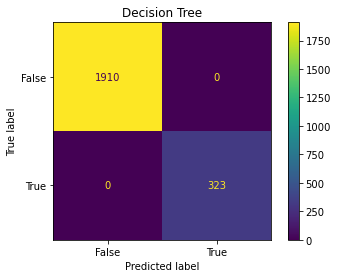

In [26]:
plot_confusion_matrix(dt_pipeline, X_train, y_train)
title = 'Decision Tree'
plt.title(title);

In [27]:
#Cross-validate decision tree

cross_val(dt_pipeline, X_train, y_train)

Mean f1 score:  {0.6813362815421017} .
Median f1 score:  {0.6824175824175824} .


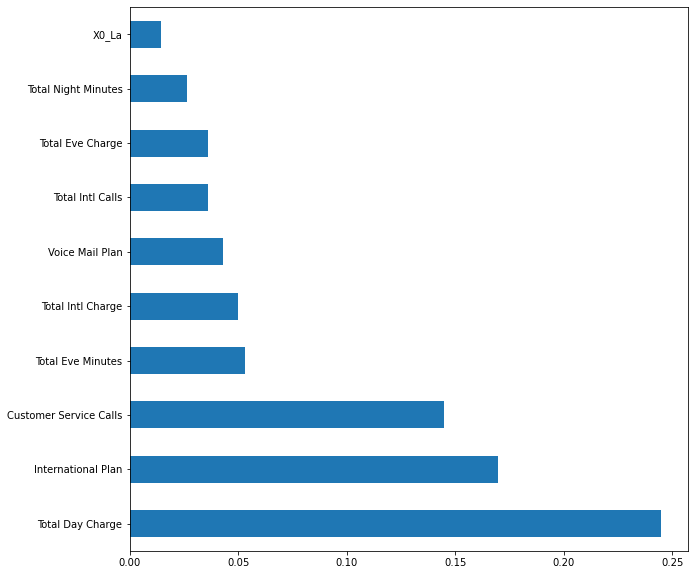

In [28]:
dt_importances = get_feature_importance(dt_pipeline, 'dt', X_train, y_train)

# KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
knn_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('knn', KNeighborsClassifier())
                                       ]
                                )

In [31]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [32]:
knn_y_hat = knn_pipeline.predict(X_train)
print(classification_report(y_train, knn_y_hat))

              precision    recall  f1-score   support

       False       1.00      0.86      0.92      1910
        True       0.54      0.98      0.70       323

    accuracy                           0.88      2233
   macro avg       0.77      0.92      0.81      2233
weighted avg       0.93      0.88      0.89      2233



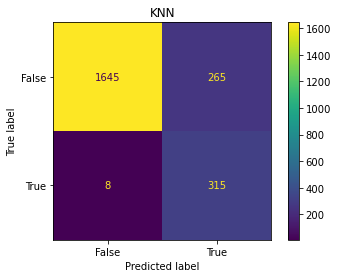

In [33]:
plot_confusion_matrix(knn_pipeline, X_train, y_train)
title = 'KNN'
plt.title(title);

In [34]:
cross_val(knn_pipeline, X_train, y_train)

Mean f1 score:  {0.44515018728655065} .
Median f1 score:  {0.4341013824884793} .


# Logistic Regression

In [35]:
lr_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('lr', LogisticRegression(random_state=42))
                                       ]
                                )

In [36]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [37]:
lr_y_hat = lr_pipeline.predict(X_test)
print(classification_report(y_test, lr_y_hat))

              precision    recall  f1-score   support

       False       0.93      0.82      0.87       940
        True       0.38      0.65      0.48       160

    accuracy                           0.80      1100
   macro avg       0.66      0.74      0.68      1100
weighted avg       0.85      0.80      0.82      1100



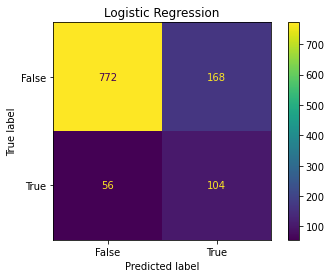

In [38]:
plot_confusion_matrix(lr_pipeline, X_test, y_test)
title = 'Logistic Regression'
plt.title(title);

In [39]:
cross_val(lr_pipeline, X_train, y_train)

Mean f1 score:  {0.47585886006760036} .
Median f1 score:  {0.4835748792270531} .


# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('rf', RandomForestClassifier(random_state=42))
                                       ]
                                )

In [42]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [43]:
rf_y_hat = rf_pipeline.predict(X_test)
print(classification_report(y_test, rf_y_hat))

              precision    recall  f1-score   support

       False       0.95      0.98      0.97       940
        True       0.88      0.72      0.79       160

    accuracy                           0.95      1100
   macro avg       0.92      0.85      0.88      1100
weighted avg       0.94      0.95      0.94      1100



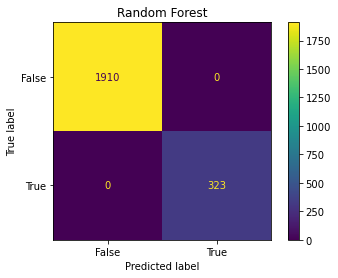

In [44]:
plot_confusion_matrix(rf_pipeline, X_train, y_train)
title = 'Random Forest'
plt.title(title);

In [45]:
cross_val(rf_pipeline, X_train, y_train)

Mean f1 score:  {0.7554505669905633} .
Median f1 score:  {0.7627118644067796} .


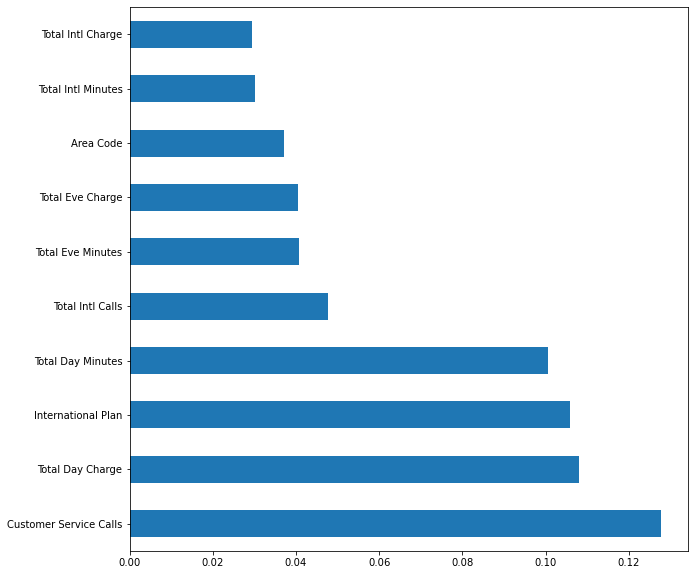

In [46]:
rf_importances = get_feature_importance(rf_pipeline, 'rf', X_train, y_train)

## Grid Search--Random Forest Classifier

In [60]:
#



In [66]:
# Print out original parameters of rf classifier in rf_pipeline
print('Current Parameters:\n')
pprint(rf_pipeline.named_steps['rf'].get_params())

Current Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [91]:
rf_params = {
            'rf__n_estimators': [10, 20, 30],
            'rf__min_samples_leaf': [1, 2, 4, 6],
            'rf__min_samples_split': [2, 5, 10],
            'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'rf__bootstrap': [True, False]
             }

In [92]:
rf_gs = GridSearchCV(rf_pipeline, param_grid=rf_params, n_jobs=-4, verbose=3, cv=10)

In [93]:
##### THIS IS THE CELL THAT WILL TAKE FOREVER, DONT RUN UNLESS YOU'RE SURE ####
rf_gs.fit(X_train, y_train)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-4)]: Done 281 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-4)]: Done 921 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-4)]: Done 1817 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-4)]: Done 2969 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-4)]: Done 4377 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-4)]: Done 6041 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-4)]: Done 7200 out of 7200 | elapsed:  1.9min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num',
                                                                                          FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['account '
                                                                          'length',
                                                                          'area '
                                                                          'code',
                                                  

In [95]:
rf_gs.best_params_

{'rf__bootstrap': False,
 'rf__max_depth': 30,
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 20}

# Naive Bayes

In [47]:
from sklearn.naive_bayes import GaussianNB

In [48]:
nb_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('nb', GaussianNB())
                                       ]
                                )

In [49]:
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [50]:
nb_y_hat = nb_pipeline.predict(X_train)
print(classification_report(y_train, nb_y_hat))

              precision    recall  f1-score   support

       False       0.91      0.56      0.70      1910
        True       0.21      0.69      0.32       323

    accuracy                           0.58      2233
   macro avg       0.56      0.63      0.51      2233
weighted avg       0.81      0.58      0.64      2233



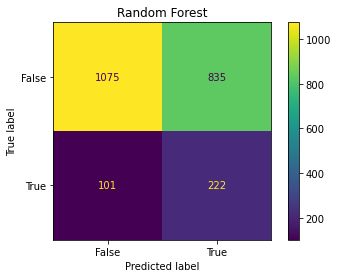

In [51]:
plot_confusion_matrix(nb_pipeline, X_train, y_train)
title = 'Random Forest'
plt.title(title);

In [52]:
cross_val(nb_pipeline, X_train, y_train)

Mean f1 score:  {0.2815993245174138} .
Median f1 score:  {0.28008130081300814} .


# Gradiant Boosted 

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
gbc_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('gbc', GradientBoostingClassifier())
                                       ]
                                )

In [55]:
gbc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [56]:
gbc_y_hat = gbc_pipeline.predict(X_train)
print(classification_report(y_train, gbc_y_hat))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1910
        True       0.92      0.80      0.86       323

    accuracy                           0.96      2233
   macro avg       0.94      0.90      0.92      2233
weighted avg       0.96      0.96      0.96      2233



In [57]:
cross_val(gbc_pipeline, X_train, y_train)

Mean f1 score:  {0.7889990265068221} .
Median f1 score:  {0.7793103448275862} .


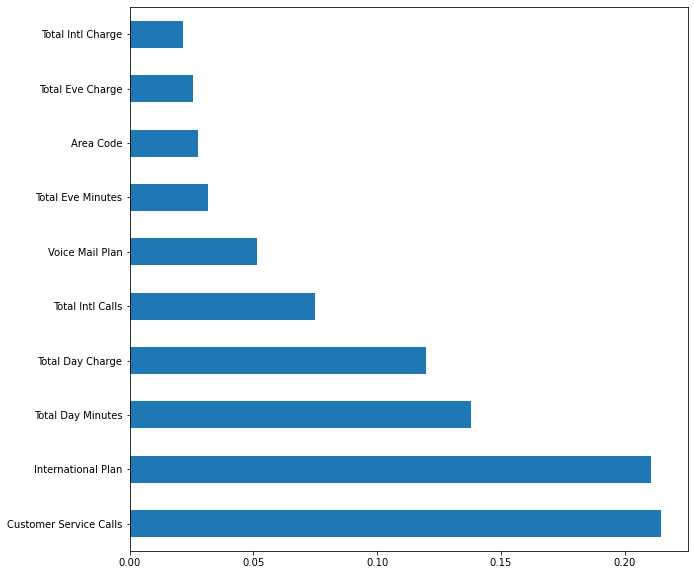

In [58]:
gbc_importances = get_feature_importance(gbc_pipeline, 'gbc', X_train, y_train)

## GridSearch--Gradiant Boosted Classifier

In [85]:
# Print out original parameters of rf classifier in gbc_pipeline
print('Current Parameters:\n')
pprint(gbc_pipeline.named_steps['gbc'].get_params())

Current Parameters:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [101]:
gbc_params = {
            'gbc__n_estimators': [10, 20, 30],
            'gbc__min_samples_leaf': [1, 2, 4, 6],
            'gbc__min_samples_split': [2, 3, 4, 5, 10],
            'gbc__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'gbc__learning_rate': [0.05, 0.1, 0.2, 0.3]
             }

In [102]:
gbc_gs = GridSearchCV(gbc_pipeline, param_grid=gbc_params, n_jobs=-4, verbose=3, cv=10)

In [103]:
#### TTHIS IS THE LONG-RUNNER####

gbc_gs.fit(X_train, y_train)


Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-4)]: Done 114 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-4)]: Done 274 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-4)]: Done 498 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-4)]: Done 786 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-4)]: Done 1138 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-4)]: Done 1554 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-4)]: Done 2034 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-4)]: Done 2578 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-4)]: Done 3186 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-4)]: Done 3858 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-4)]: Done 4594 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-4)]: Done 5394 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-4)]: Done 6258 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-4)]: Done 7186 tasks      | e

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num',
                                                                                          FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['account '
                                                                          'length',
                                                                          'area '
                                                                          'code',
                                                  

In [104]:
gbc_gs.best_params_

{'gbc__learning_rate': 0.3,
 'gbc__max_depth': 10,
 'gbc__min_samples_leaf': 4,
 'gbc__min_samples_split': 4,
 'gbc__n_estimators': 30}